# Problem 12.1

**Integrated Energy Grids**

**Problem 12.1. Hydrogen production in an energy island.**

**In this problem, we want to build a stylized mode of hydrogen production in an energy island. Assume an offshore generator and an electrolyzer with the cost in Table. For the offshore generator, assume the [capacity factors for Denmark](https://zenodo.org/record/3253876#.XSiVOEdS8l0).**

**An annual hydrogen demand of 200 GWh must be delivered and, for the sake of simplicity, assume that the island includes a hydrogen storage with no cost. The electrolyzer efficiency is assumed to be 62\%.**

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `numpy` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pypsa

Set parameter Username
Set parameter LicenseID to value 2767832
Academic license - for non-commercial use only - expires 2027-01-20


## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onffhore wind and electrolysis

In [9]:
costs.at["offwind", "capital_cost"] #EUR/MW/a

np.float64(174556.22307975945)

In [10]:
costs.at["electrolysis", "capital_cost"] #EUR/MW/a

np.float64(188715.7758309984)

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [11]:
data_offwind = pd.read_csv('data/offshore_wind_1979-2017.csv',sep=';')
data_offwind.index = pd.DatetimeIndex(data_offwind['utc_time'])


The data format can now be analyzed using the .head() function to show the first lines of the data set

In [12]:
data_offwind.head()

,utc_time,BEL,DEU,DNK,GBR,NLD,SWE,FIN,FRA,IRL,NOR
utc_time,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.513,0.875,0.986,0.522,0.484,0.712,0.470,0.296,0.676,0.232
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.367,0.861,0.985,0.549,0.322,0.713,0.384,0.331,0.584,0.180
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.372,0.845,0.978,0.551,0.267,0.711,0.321,0.343,0.466,0.161
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.351,0.819,0.968,0.498,0.274,0.709,0.271,0.223,0.389,0.163
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.338,0.787,0.957,0.457,0.274,0.708,0.224,0.189,0.270,0.168


We will use timeseries for Denmark in this excercise

In [13]:
country = 'DNK'

### Join capacity and dispatch optimization

For building the model, we start again by initialising an empty network, adding the snapshots, the electricity and the hydrogen bus.

In [14]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus", "electricity")
n.add("Bus", "hydrogen")
n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

Next, we add the hydrogen demand time series to the model. 
We add a "free" H2 store in the hydrogen bus. 

In [15]:
annual_hydrogen_demand = 200000 #MWh
hydrogen_demand = annual_hydrogen_demand/8760*np.ones(8760)
n.add("Load",
      "hydrogen demand",
      bus = "hydrogen",
      p_set=hydrogen_demand)

n.add("Store",
      "hydrogen store",
      bus = "hydrogen",
      e_nom_extendable=True,
       e_cyclic=True)  # cyclic state of charge

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

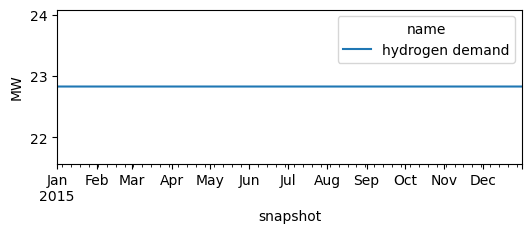

In [16]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the offshore wind generator and set up the capacity to be extendable so that it can be optimized. We need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [17]:
CF_wind = data_offwind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "offwind",
        bus="electricity",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["offwind", "capital_cost"],
        marginal_cost=costs.at["offwind", "marginal_cost"],
        p_nom_extendable=True,
    )


So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

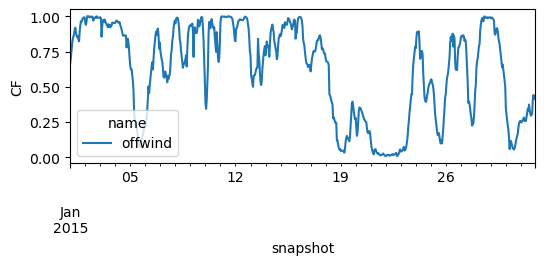

In [18]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

We add the electrolyzer. 

In [19]:
n.add(
    "Link",
    "electrolysis",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    efficiency=costs.at["electrolysis", "efficiency"],
    capital_cost=costs.at["electrolysis", "capital_cost"] #EUR/MW/a, 
)

### Model Run

We can already solve the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [20]:
n.optimize(solver_name="highs")

Index(['electricity', 'hydrogen'], dtype='object', name='name')
Index(['electrolysis'], dtype='object', name='name')
Index(['hydrogen store'], dtype='object', name='name')


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 105.77it/s]
INFO:linopy.io: Writing time: 1.24s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-_plxxc4z has 78843 rows; 35043 cols; 140163 nonzeros
Coefficient ranges:
  Matrix  [3e-03, 1e+00]
  Cost    [2e-02, 2e+05]
  Bound   [0e+00, 0e+00]
  RHS     [2e+01, 2e+01]
Presolving model
26280 rows, 17522 cols, 61320 nonzeros  0s
Dependent equations search running on 8760 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
26280 rows, 17522 cols, 61320 nonzeros  0s
Presolve reductions: rows 26280(-52563); columns 17522(-17521); nonzeros 61320(-78843) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(200000) 0s
       7875     4.5185530675e+03 Pr: 5916(5.49299e+07) 5s
      12932     1.0221487803e+04 Pr: 3381(5.44112e+07) 10s
      16855     1.8491863054e+04 Pr: 666(5.68404e+06) 15s
      18284    

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35043 primals, 78843 duals
Objective: 2.71e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [21]:
n.objective / 1e9

0.02712067340606581

**a) What is the optimum capacity of offshore wind and electrolyzer that needs to be installed?**

The optimised capacities in GW, notice that we are representing some technologies using generator components and other using link components, so we need to check both.

In [22]:
n.generators.p_nom_opt

name
offwind    88.30876
Name: p_nom_opt, dtype: float64

In [23]:
n.links.p_nom_opt

name
electrolysis    61.992749
Name: p_nom_opt, dtype: float64

**b) What is the optimal storage capacity of hydrogen, in absolute terms and relative to the annual demand?**

In [24]:
n.stores.e_nom_opt

name
hydrogen store    19955.611164
Name: e_nom_opt, dtype: float64

The optimal energy capacity of the hydrogen storage represents 5% of the annual hydrogen demand

In [25]:
n.stores.e_nom_opt['hydrogen store']/n.loads_t.p_set['hydrogen demand'].sum()

np.float64(0.09977805582196332)

**c) Plot the duration curve for offshore wind generation and electrolyzer operation and discuss the results.  Compare the capacity factor corresponding to wind power availability and the utilization factor for the electrolyzer.**

Even though electrolysis capacity is expensive, it is sized to obtain an utilization factor of 0.59.

Text(0.5, 0, 'hours')

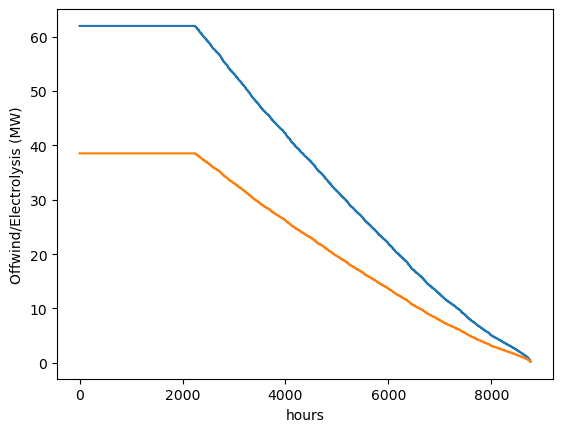

In [26]:
duration_offwind=n.generators_t.p["offwind"].sort_values(ascending=False)
duration_electrolysis=-n.links_t.p1["electrolysis"].sort_values(ascending=True)
plt.plot(duration_offwind.values)
plt.plot(duration_electrolysis.values)
plt.ylabel("Offwind/Electrolysis (MW)")
plt.xlabel("hours")

In [27]:
(duration_electrolysis/duration_electrolysis.max()).mean()

np.float64(0.5923850967229962)

The Capacity Factor (CF) for offshore wind can be calculated as

In [28]:
n.generators_t.p_max_pu["offwind"].mean()

np.float64(0.4562141552511415)

**At what cost can the H$_2$ be produced and how does it compare to current H$_2$ price?**

We can calculate the cost ob producing H$_2$ by using the total system cost or averaging the marginal price of the hydrogen bus. 

In [29]:
n.objective / n.loads_t.p_set['hydrogen demand'].sum()

np.float64(135.60336703032905)

In [30]:
n.buses_t.marginal_price['hydrogen'].mean()

np.float64(135.60336703031334)

Assuming 33 kWh/kg of Hydrogen, 146 EUR/MWh corresponds to 4.8 EUR/kg while the current price for hydrogen produced via steam methane reforming is around 1.5 EUR/kg (while emitting CO2)

In [31]:
146/1000*33

4.818